# English to French translation with transformers

The aim of this notebook is to train an English to French translation system using the transformer encoder-decoder architecture introduced in the paper *Attention is all you need*.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
import torchtext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from time import time

## Model

In [2]:
N_in = 7 # Length of input sentences
N_out = 8 # Length of output sentences
emb_size = 300 # Size of embedded vectors
n_layers = 6 # Number of layers for encoder and decoder stacks
nhead = 6 # Number of heads in multihead attention layers
dim_feedforward = 1024 # Number of hidden neurons in positionwise-FCNN 
dim_out_hidden = 1024 # Number of hidden neurons in output FCNN
dropout = 0.1 # Dropout value
num_fr_words = 2000 # Length of French word list

The model is split into an encoding step and a decoding step. 

Encoding step:
- **Raw input**: English sentence consisting of a sequence of `N_in` strings (words and other tokens such as `<eos>`and `<pad>`). 
- **Embedding**: FastText converts each sentence into a sequence of `N_in` float vectors of size `emb_size`
- **Encoder stack**: Given the sequence of `N_in` embedded vectors, the encoder stack outputs a sequence of `N_in` vectors of the same size `emb_size`, intended to be a latent representation of the input sentence. The encoder stack consists in first adding a positional encoding signal to the input, then applying `n_layers` "Transformer encoder" layers. Each transformer encoder layer consists of two sub-layers: a multi-head self-attention layer (with `nhead` heads) and a positionwise-FCNN (single hidden layer with `dim_feedforward` neurons), with residual connections and layer-normalisation applied after each sub-layer.

For the decoding step of the model we need the following element:
- **French word-list**: A list `fr_wordlst` of French words and punctuation from which the model will construct its output. The word-list also includes a end-of-sentence token `<eos>`.

The decoder stack starts with a sequence `output` with only one element, the beginning of sentence token `<bos>`. The model then iteratively generates the next word/token of the ouput sentence and appends it to the `output` sequence until:
- **Termination condition**: Either the end of sentence token `<eos>` is generated or the sequence output reaches a length `N_out` (including the `<bos>` token). 

The generation of the next word is performed as follows:
- **Embedding**: FastText converts each word/token of the current instance of the sequence `translation`into a vector of size `emb_size`
- **Decoder stack**: Given the above sequence of vectors, the decoder stack outputs a sequence of vectors of the same size. The decoder stack consists in `n_layers` "Transformer decoder" layers. Each transformer decoder layer consists of three sub-layers: a multi-head self-attention layer applied to the embedding of the sequence `translation`, a multi-head "encoder-decoder" attention layer (the queries and values come from the output of the encoder stack and the queries come from the previous self-attention layer) and a positionwise-FCNN. A residual connection and layer normalisation is applied after each sub-layer. The number of heads in both multi-head attention layers is `nhead` and the positionwise-FCNN has a single hidden layer with `dim_feedforward` neurons.
- **Output layer**: An FCNN with a single hidden layer (`dim_out_hidden` neurons), applied to the final vector of the decoder output, followed by a softmax function, gives a probability distribution of the French word-list `fr_wordlst`. The next word with the highest probability is appended onto `translation`.

Training of the model shall be performed as follows:
- **Training dataset**: The input variables are the English sentence and the first $N$ words/tokens of the French translation, where $N$ varies from 1 (just the `<bos>` token) to the entire length of the translation sequence. The target variable is the next word of the translation or the `<eos>` token if the entire translation is given as input.
- **Loss function**: Cross-entropy loss function is used to compare the probability distribution over `fr_wordlst` outputted by the model with a one-hot vector representing the target variable. If the target variable is not in `fr_wordlst`, then we set the loss to zero.
- **Regularisation**: Dropout with value `dropout`.

#### Embedding layers

First, we create two functions which take in a sentence (English or French resp.) and outputs a 2d PyTorch tensor representing a sequence of vectors. We use fastText, which provides vectors for words and punctuation.
* Unknown token `<unk>` is represented by the zero vector.
* Beginning of sentence token `<bos>`  is represented by `2*torch.ones(emb_size)`.
* Padding token `<pad>` is represented by `- 2*torch.ones(emb_size)`.

**To do** `<eos>` token not `<pad>` token 

In [3]:
# French embedding
vocab_fr = torchtext.vocab.Vectors('/kaggle/input/fasttext-french-2b-300d/cc.fr.300.vec',max_vectors = 30000)
# English embedding
vocab_en = torchtext.vocab.Vectors('/kaggle/input/fasttext-wikinews/wiki-news-300d-1M.vec',max_vectors = 30000)


100%|██████████| 30000/30000 [00:04<00:00, 6973.27it/s]


In [4]:
# example 1
sent_en = 'The dogs ate .'
print(vocab_en.get_vecs_by_tokens(sent_en.split(' ')))

tensor([[ 0.0797, -0.0294,  0.0033,  ...,  0.1372,  0.0669, -0.0084],
        [-0.1179,  0.0636, -0.0078,  ...,  0.0994,  0.0352, -0.0196],
        [ 0.0752,  0.1227,  0.1374,  ...,  0.1154, -0.0208, -0.0434],
        [ 0.0004,  0.0032, -0.0204,  ...,  0.2070,  0.0689, -0.0467]])


In [5]:
# example 2
sent_fr = "Les chiens a mange ?"
print(vocab_fr.get_vecs_by_tokens(sent_fr.split(' ')))

tensor([[-0.0594,  0.0330, -0.0503,  ...,  0.1932, -0.0023,  0.0341],
        [ 0.0084,  0.0216,  0.0323,  ...,  0.0561,  0.0040,  0.1386],
        [ 0.0092,  0.0073, -0.2033,  ..., -0.1730,  0.0966,  0.0489],
        [ 0.1356, -0.0000, -0.0007,  ...,  0.0340,  0.0039,  0.0621],
        [ 0.1828, -0.1425, -0.1679,  ..., -0.3886, -0.1527,  0.0675]])


Words such as "we're" and "c'est" are not recognised by the word embedding algorithms. 

This is why we treat them as multiple tokens, i.e. [we,',re] and [c,',est] resp. 

In [6]:
# example 3a
print(torch.norm(vocab_en["we're"]),torch.norm(vocab_en["we"]),torch.norm(vocab_en["'"]),torch.norm(vocab_en["re"]))
# example 3b
print(torch.norm(vocab_fr["puisqu'il"]),torch.norm(vocab_fr["puisqu'"]), torch.norm(vocab_fr["puisqu"]), torch.norm(vocab_fr["'"]), torch.norm(vocab_fr["il"]))

tensor(0.) tensor(2.1135) tensor(1.4133) tensor(1.9807)
tensor(0.) tensor(0.5633) tensor(0.6729) tensor(2.5800) tensor(3.0775)


#### French word-list

Importing a previously prepared list of French words as a Pandas Series and truncating to `num_fr_words` words.

In [7]:
fr_wordlst = pd.read_csv("/kaggle/input/list-of-french-words/french_counter.txt").iloc[:num_fr_words,1]

#### Encoder and decoder stacks

The encoder and decoder stacks  are conveniently available as a pre-implemented module in PyTorch.

In [8]:
enc_dec = torch.nn.Transformer(d_model=emb_size, nhead=nhead, num_encoder_layers=n_layers, num_decoder_layers=n_layers,
                               dim_feedforward = dim_feedforward, dropout=dropout, batch_first=True)
# Examples: unbatched data
src = torch.rand((N_in,emb_size)) # Input into encoder
tgt = torch.rand((1,emb_size)) # Input into decoder
print(enc_dec(src,tgt).shape)
src = torch.rand((N_in,emb_size))
tgt = torch.rand((8,emb_size))
print(enc_dec(src,tgt).shape)
# Examples: unbatched data
nbatch = 10
src = torch.rand((nbatch,N_in,emb_size)) 
tgt = torch.rand((nbatch,4,emb_size))
print(enc_dec(src,tgt).shape)


torch.Size([1, 300])
torch.Size([8, 300])
torch.Size([10, 4, 300])


#### Construction of model

In [9]:
class TranslationSystem(nn.Module):
    
    def __init__(self, fr_wordlst, # List of French words 
                       N_in = 7, # Length of input sentences
                       N_out = 8, # Length of output sentences
                       emb_size = 300, # Size of embedded vectors
                       n_layers = 6, # Number of layers for encoder and decoder stacks
                       nhead = 6, # Number of heads in multihead attention layers
                       dim_feedforward = 1024, # Number of hidden neurons in positionwise-FCNN 
                       dim_out_hidden = 1024, # Number of hidden neurons in output FCNN
                       dropout = 0.1 # Dropout value
                ):
        super(TranslationSystem,self).__init__()
        
        self._num_fr_words = len(fr_wordlst)
        self._wordlst_full = pd.concat([fr_wordlst, pd.Series(['<eos>'])],ignore_index=True)
        self.bos_vec = 2*torch.ones(emb_size)
        
        self.enc_dec = torch.nn.Transformer(d_model=emb_size, nhead=nhead, num_encoder_layers=n_layers, num_decoder_layers=n_layers,
                               dim_feedforward = dim_feedforward, dropout=dropout, batch_first=True)
        
        self.fc_out1 = nn.Linear(emb_size,dim_out_hidden)
        self.fc_out2 = nn.Linear(dim_out_hidden,self._num_fr_words + 1)
        
    def forward(self,X, Y):
        '''
        Outputs a logit probability distribution (pre-softmax) over `fr_wordlst` given batch of pre-embedded sentences.
        `X`: Input
        `Y`: Partial output (including <bos> token)
        '''
        out_seq = self.enc_dec(X,Y)
        a1 = F.relu(self.fc_out1(out_seq[:,-1,:]))
        logits = self.fc_out2(a1)
        return logits
    
    @staticmethod
    def pre_process(sent):
        '''
        Pre-processing pipeline from data preparation
        '''
        sent = sent.lower() # Make data lowercase
        sent = sent.replace('.','').replace('!','') # Remove full stops and exclamation marks.
        sent = sent.replace('?',' ? ').replace(',',' , ') # Replace "?" by " ? " and "," by " , "
        sent = sent.replace('-',' - ').replace("'"," ' ") # Replace "-" by " - " and "'" by " ' "
        sent = re.sub('\xa0|\xad|\u2009|\u200b|\u202f',' ', sent) # Replace unbreakable spaces by spaces.
        sent = re.sub('   ',' ', sent) # Removing triple spaces
        sent = re.sub('  ',' ', sent)  # Removing double spaces
        sent = re.sub('^ ','', sent) # remove leading space
        sent = re.sub(' $','', sent) # remove trailing space
        return sent
    
    def next_word(self, sent_en, sent_fr, vocab_en = vocab_en, vocab_fr = vocab_fr):
        '''
        Outputs the next word of the French translation given a single English-French sentence pair
        '''
        sent_en = self.pre_process(sent_en); sent_fr = self.pre_process(sent_fr)
        X_raw = vocab_en.get_vecs_by_tokens(sent_en.split(' '))
        pad_seq = - 2*torch.ones(N_in - X_raw.shape[0],emb_size)
        X = torch.concat([X_raw, pad_seq],dim=0).reshape(1,N_in,emb_size) # append <pad> vectors
        Y_raw = vocab_fr.get_vecs_by_tokens(sent_fr.split(' '))
        Y = torch.concat([self.bos_vec.unsqueeze(dim=0),Y_raw],dim=0).unsqueeze(dim=0) # prepend <bos> vector
        idx_maxprob = torch.argmax(self.forward(X,Y)).item()
        return self._wordlst_full.iloc[idx_maxprob]
    
    def translate(self, sent_en, vocab_en = vocab_en, vocab_fr = vocab_fr):
        '''
        Outputs the French translation of a single English sentence
        '''
        sent_en = self.pre_process(sent_en)
        sent_fr = ''
        X_raw = vocab_en.get_vecs_by_tokens(sent_en.split(' '))
        pad_seq = - 2*torch.ones(N_in - X_raw.shape[0],emb_size)
        X = torch.concat([X_raw, pad_seq],dim=0).reshape(1,N_in,emb_size) # append <pad> vectors
        Y = self.bos_vec.reshape(1,1,emb_size)
        for n in range(N_out):
            idx_maxprob = torch.argmax(self.forward(X,Y)).item()
            next_word_str = self._wordlst_full.iloc[idx_maxprob]
            if next_word_str == '<eos>':
                break
            sent_fr += ' ' + next_word_str
            next_word_vec = vocab_fr[next_word_str]
            Y = torch.concat([Y,next_word_vec.reshape(1,1,emb_size)],dim = 1)
        sent_fr = sent_fr[1:] # Removes leading space
        return sent_fr


In [10]:
# Test forward
model = TranslationSystem(fr_wordlst)
src = torch.rand((2,N_in,emb_size)) # Input into encoder
tgt = torch.rand((2,4,emb_size)) # Input into decoder
probs = model(src,tgt)
print(probs.shape)

torch.Size([2, 2001])


In [11]:
# Test pre_process
print(TranslationSystem.pre_process("Hello, we're  testing "))

hello , we ' re testing


In [12]:
# Test next_word 
model = TranslationSystem(fr_wordlst)
model.next_word('there is a car', 'il y a')

'sort'

In [13]:
# Test translate
model = TranslationSystem(fr_wordlst)
model.translate('there is a car')

'stylo salon chanter chanter chanter venir pleure court'

## Importing dataset

First, we import a previously prepared dataset consisting of English-French sentence pairs (see the notebook "Transformers-EnFr-DatasetCleaning").

In [14]:
dataset_str = pd.read_csv("/kaggle/input/enfr-cleaned/EnFr_cleaned.txt").iloc[:,1:]
dataset_str

,En,Fr
0,go,va
1,hi,salut
2,run,cours
3,who ?,qui ?
4,wow,ça alors
...,...,...
53864,his helplessness appeals to her motherly sympathy,son impuissance éveille sa compassion maternelle
53865,the conflict began over a simple misunderstanding,le conflit commença sur un simple malentendu
53866,the students divided themselves into three groups,les étudiants se divisèrent en trois groupes
53867,draw two concentric circles of differing diame...,tracez deux cercles concentriques de diamètres...


Importing embedded sentences pairs, with appropriate padding and with `<bos>` prepended to the French token sequences.

In [15]:
X_en, X_fr  = torch.load('/kaggle/input/tensorised-enfr-sentence-pairs/EnFr_tensors.pt').tensors

Creating the target data: the sequence of indices in the French word list corresponding to each French sentence. The target data shall differ between the cases of training models with and without terminations.

When training models with termination, the target set is denoted by `Ystop` and shall run over indices `[0,...,2001]` with index 2000 marking padding tokens. We mark unknown words (words not in `fr_wordlst`) the index 2001, which shall act as an "ignore" index in this case (datapoints with this target index won't contribute to the cost function).

When training models without termination, the target set is denoted by `Ycont` and shall run over indices `[0,...,2000]`, where we mark both padding tokens and unknown with an "ignore" index 2000.


In [16]:
# Example 
sentence = 'je suis blahblah une personne'
wordlst_full = pd.concat([fr_wordlst, pd.Series(['<eos>','<unk>'])],ignore_index=True)
word_to_idx = {v: k for k, v in dict(wordlst_full).items()}
seq_short = torch.tensor([word_to_idx.get(word,2001) for word in sentence.split(' ')])
seq = torch.concat([seq_short,2000*torch.ones(N_out - len(seq_short), dtype = torch.int64)])
print(seq)

tensor([   0,   36, 2001,   13,   58, 2000, 2000, 2000])


In [17]:
wordlst_full = pd.concat([fr_wordlst, pd.Series(['<eos>','<unk>'])],ignore_index=True)
word_to_idx = {v: k for k, v in dict(wordlst_full).items()}
sentence = dataset_str.Fr.iloc[0]
seq_short = torch.tensor([word_to_idx.get(word,2001) for word in sentence.split(' ')])
seq = torch.concat([seq_short,2000*torch.ones(N_out - len(seq_short), dtype = torch.int64)])
Y = seq.unsqueeze(0)
for sentence in tqdm(dataset_str.Fr.iloc[1:]):
    seq_short = torch.tensor([word_to_idx.get(word,2001) for word in sentence.split(' ')])
    seq = torch.concat([seq_short,2000*torch.ones(N_out - len(seq_short), dtype = torch.int64)])
    Y = torch.concat([Y, seq.unsqueeze(0)], dim = 0)
    

100%|██████████| 53868/53868 [00:11<00:00, 4740.80it/s]


Creating a PyTorch dataset structure encompassing the embedded English sentences, embedded French sentences, index sequences for the French sentences and the original index of the sentence pair (for reference back to the non-embedded dataset `dataset_str` after randomised test-train split).

In [18]:
class SentencePairs(Dataset):
    def __init__(self, X_en, X_fr, Y):
        assert X_en.shape[0] ==  X_fr.shape[0] ==  Y.shape[0]
        self.X_en = X_en
        self.X_fr = X_fr
        self.Y = Y
        self.original_index = torch.tensor(range(self.Y.shape[0]))
    
    def __len__(self):
        return self.Y.shape[0]
    
    def __getitem__(self, index):
        return self.X_en[index,:,:], self.X_fr[index,:,:], self.Y[index,:], self.original_index[index]
    

Initialising the dataset and performing a test-train split with 80% training data.

In [19]:
dataset = SentencePairs(X_en, X_fr, Y)
trainset, valset = torch.utils.data.random_split(dataset, [0.8, 0.2])


## Training loop

Main training loop:

In [20]:
def give_cost_0(dataset, model, loss_fn):
    'Cost for predicting first word (for evaluation while training)'
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)
    cost = 0
    for X_en, X_fr, Y, idx in dataloader:
        X_en =  X_en.to(device); X_fr =  X_fr.to(device); Y =  Y.to(device)
        N = 0 
        Xfr_trunc = X_fr[:,:N+1,:] 
        outputs = model(X_en,Xfr_trunc)
        labels = Y[:,N]
        loss = loss_fn(outputs,labels) 
        cost += loss.item()
    return cost/len(dataloader)

def give_cost_all(dataset, model):
    'Costs for predicting all word (for final evaluation)' 
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)
    ignore_index = 2001
    loss_fn = nn.CrossEntropyLoss(ignore_index=ignore_index) 
    
    cost_lst = [0 for N in range(N_out)]
    for X_en, X_fr, Y, idx in tqdm(dataloader):
        X_en =  X_en.to(device); X_fr =  X_fr.to(device); Y =  Y.to(device)
        for N in range(N_out):
            Xfr_trunc = X_fr[:,:N+1,:] 
            outputs = model(X_en,Xfr_trunc)
            labels = Y[:,N]
            loss = loss_fn(outputs,labels) 
            if loss.item() > 0:
                cost_lst[N] += loss.item()
    return [cost/len(dataloader) for cost in cost_lst]


def train(model, optimiser, n_epochs, batch_size, train_set, val_set, device, printing):
    dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    ignore_index = 2001
    loss_fn = nn.CrossEntropyLoss(ignore_index=ignore_index) 
    
    start = time()
    
    cost_hist = {N : [] for N in range(N_out + 1)}
    run_train_hist = []

    # Initial validation cost
    start_val_cost = give_cost_0(val_set, model, loss_fn)
    val_hist = [start_val_cost]
    print('Initial validation cost: ', start_val_cost)
    
    best_model = model
    best_epoch = (0,start_val_cost)
    step = 0
    for n in range(n_epochs):
        epoch_train_cost = 0
        for X_en, X_fr, Y, idx in dataloader:
            X_en =  X_en.to(device); X_fr =  X_fr.to(device); Y =  Y.to(device)
            
            # Generate random value of N according to skewed distribution
            N = np.random.randint(N_out - 1)
            # Take first N + 1 tokens in French sentences (including <bos>) 
            Xfr_trunc = X_fr[:,:N+1,:]
            
            # Training step
            optimiser.zero_grad()
            outputs = model(X_en,Xfr_trunc)
            labels = Y[:,N]
            loss = loss_fn(outputs,labels)
            loss.backward()
            optimiser.step()

            # Bookkeeping
            cost_hist[N].append((loss.item(),step))
            if loss.item() > 0:
                epoch_train_cost += loss.item()
            step += 1
            
        epoch_train_cost /= len(dataloader)
        run_train_hist.append(epoch_train_cost)
        epoch_val_cost = give_cost_0(val_set, model, loss_fn)
        val_hist.append(epoch_val_cost)
        if epoch_val_cost < best_epoch[1]:
            best_model = model
            best_epoch = (n+1, epoch_val_cost)
        if printing == True:
            print(f'Epoch {n + 1}. Train cost: {epoch_train_cost}. Val cost: {epoch_val_cost}')    
    end = time()
    print(f'Best epoch: {best_epoch[0]}')
    print(f'Time taken: {end - start} seconds')
    
    return cost_hist, run_train_hist, val_hist, best_model, best_epoch

def run_tests(model,cost_hist, run_train_hist, val_hist):
    plt.plot(run_train_hist, label = 'train')
    plt.plot(val_hist, label = 'val')
    plt.title('epoch training curve')
    plt.legend()
    plt.show()
    model.to(device='cpu')
    print('This is a sentence: ', model.translate('This is a sentence'))
    print('another test: ', model.translate('another test'))
    print('just one more: ', model.translate('just one more'))


## Training


Initial validation cost:  7.659948303854677
Best epoch: 89
Time taken: 13623.551284313202 seconds


100%|██████████| 169/169 [00:22<00:00,  7.58it/s]


End validation costs:  [1.2098996408239624, 1.479899604292311, 1.7023527102004847, 1.7559742994562408, 1.3643361139579637, 0.9644898562389013, 0.30148190475301817, 0.02218202273821283]
sum:  8.800616152461094


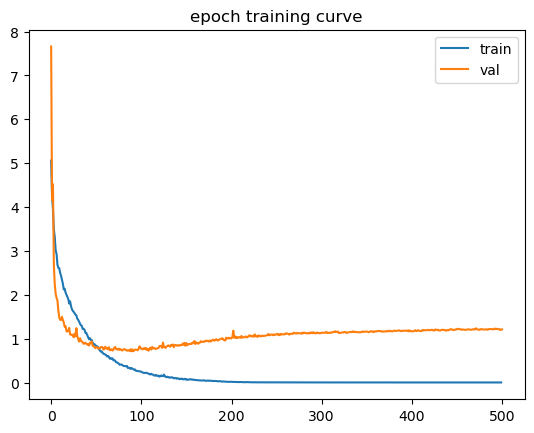

This is a sentence:  ceci est une phrase
another test:  fais un autre problème
just one more:  en simplement un simplement


In [21]:
# Training parameters
n_epochs = 500 # Number of epochs
batch_size = 64 # Batch size
dropout = 0 # Dropout value
lr = 0.01 # Learning rate
printing = False # Print after each epoch? 

# Model parameters
n_layers = 6 # Number of layers for encoder and decoder stacks
nhead = 6 # Number of heads in multihead attention layers
dim_feedforward = 1024 # Number of hidden neurons in positionwise-FCNN 
dim_out_hidden = 1024 # Number of hidden neurons in output FCNN


device = ('cuda' if torch.cuda.is_available() else 'cpu')
model = TranslationSystem(fr_wordlst, N_in = 7, N_out = 8, emb_size = 300,
                          n_layers = n_layers, nhead = nhead, dim_feedforward = dim_feedforward, 
                          dim_out_hidden = dim_out_hidden, dropout = dropout).to(device=device)
optimiser = optim.SGD(model.parameters(), lr = lr)
cost_hist, run_train_hist, val_hist, best_model, best_epoch  = train(model=model, optimiser = optimiser, n_epochs=n_epochs,
                                                                    train_set = trainset, val_set = valset, batch_size=batch_size,
                                                                    device = device, printing = printing)

costs = give_cost_all(valset, model)
print('End validation costs: ', costs)
print('sum: ', sum(costs))

run_tests(model,cost_hist, run_train_hist, val_hist)

Note that although there seems to be some overfitting here, I did not manage to improve the validation error with 0.01 dropout.

The model with the best validation error during the training process was saved as `best_model`. 

In [22]:
print('This is a sentence: ', best_model.translate('This is a sentence'))
print('another test: ', best_model.translate('another test'))
print('just one more: ', best_model.translate('just one more'))
print('the car is red: ', best_model.translate('the car is red'))
print('the dog walks: ', best_model.translate('the dog walks'))

This is a sentence:  ceci est une phrase
another test:  fais un autre problème
just one more:  en simplement un simplement
the car is red:  la voiture est rouge
the dog walks:  le chien marche


In [23]:
torch.save(model,'EnFrmodel_051023_0drop500epochs.pt')
torch.save(best_model,'EnFrbestmodel_051023_0drop500epochs.pt')